In [7]:
# preprocessing & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import spacy
import pickle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# models for classification
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [8]:
def plot_cm(pipeline, X_test, y_test):
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(pipeline, X_test, y_test)  
    plt.xticks(rotation=45, fontsize = 10)
    plt.yticks(rotation=0, fontsize = 10)
    plt.show()

In [9]:
df = pd.read_csv("data/books_def.csv", index_col=0)

In [10]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# leggo testi & etichette
X = df["book_desc"]
y = df["genres"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
with open('data/pickle/svm_train_tok.pkl',mode='br') as inputfile:
    X_train_tok = pickle.load(inputfile)
with open('data/pickle/svm_test_tok.pkl',mode='br') as inputfile:
    X_test_tok = pickle.load(inputfile)

In [15]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=5000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(X_train_tok,y_train)
predictions = RF_pipeline.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)



Classification report:
                 precision    recall  f1-score   support

       Classics       0.80      0.20      0.32       477
        Fantasy       0.55      0.74      0.63      1891
        Fiction       0.45      0.63      0.52      2134
     Historical       0.83      0.08      0.14       643
        Mystery       0.64      0.43      0.52       612
     Nonfiction       0.67      0.85      0.75      1951
        Romance       0.60      0.65      0.62      1362
Science Fiction       0.71      0.32      0.44       525
 Sequential Art       0.88      0.23      0.36       399
    Young Adult       0.59      0.32      0.42       998

       accuracy                           0.57     10992
      macro avg       0.67      0.44      0.47     10992
   weighted avg       0.61      0.57      0.54     10992

Confusion matrix:
[[  94   34  193    1    6  137    5    2    1    4]
 [   3 1395  208    1   15   84  115   21    6   43]
 [  12  226 1352    4   43  274  144   18    1   60]

In [16]:
param_grid = [{'sel__k': [3000, 5000, 7000], 'learner__n_estimators': [100, 300, 500]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier(bootstrap = True))  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
opt_search = GridSearchCV(opt_pipeline, param_grid, cv=5, n_jobs = n_jobs, verbose=True).fit(X_train_tok,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 26.6min finished


In [17]:
opt_search.best_params_


{'learner__n_estimators': 500, 'sel__k': 5000}

In [18]:
opt_search.best_estimator_


Pipeline(steps=[('sel',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x000002B7AAC57A60>)),
                ('tfidf', TfidfTransformer()),
                ('learner', RandomForestClassifier(n_estimators=500))])

In [19]:
opt_predictions = opt_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.85      0.19      0.31       477
        Fantasy       0.56      0.74      0.64      1891
        Fiction       0.46      0.65      0.54      2134
     Historical       0.90      0.09      0.16       643
        Mystery       0.68      0.46      0.55       612
     Nonfiction       0.68      0.85      0.75      1951
        Romance       0.61      0.67      0.64      1362
Science Fiction       0.74      0.35      0.47       525
 Sequential Art       0.89      0.23      0.37       399
    Young Adult       0.58      0.33      0.42       998

       accuracy                           0.58     10992
      macro avg       0.69      0.46      0.48     10992
   weighted avg       0.63      0.58      0.55     10992

Confusion matrix:
[[  90   31  194    0    6  145    4    2    1    4]
 [   2 1407  200    0   17   81  118   16    6   44]
 [   7  201 1383    4   38  269  154   22    0   56]

In [20]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=5000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(X_train_tok,y_train)
predictions = RF_pipeline.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.83      0.22      0.34       477
        Fantasy       0.55      0.74      0.63      1891
        Fiction       0.45      0.64      0.53      2134
     Historical       0.85      0.09      0.16       643
        Mystery       0.68      0.45      0.54       612
     Nonfiction       0.66      0.85      0.74      1951
        Romance       0.61      0.64      0.62      1362
Science Fiction       0.74      0.35      0.47       525
 Sequential Art       0.88      0.19      0.31       399
    Young Adult       0.57      0.32      0.41       998

       accuracy                           0.57     10992
      macro avg       0.68      0.45      0.48     10992
   weighted avg       0.62      0.57      0.55     10992

Confusion matrix:
[[ 103   31  185    0    5  141    5    2    0    5]
 [   3 1406  218    0   16   84  112   12    6   34]
 [   8  218 1361    5   41  280  141   19    0   61]

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

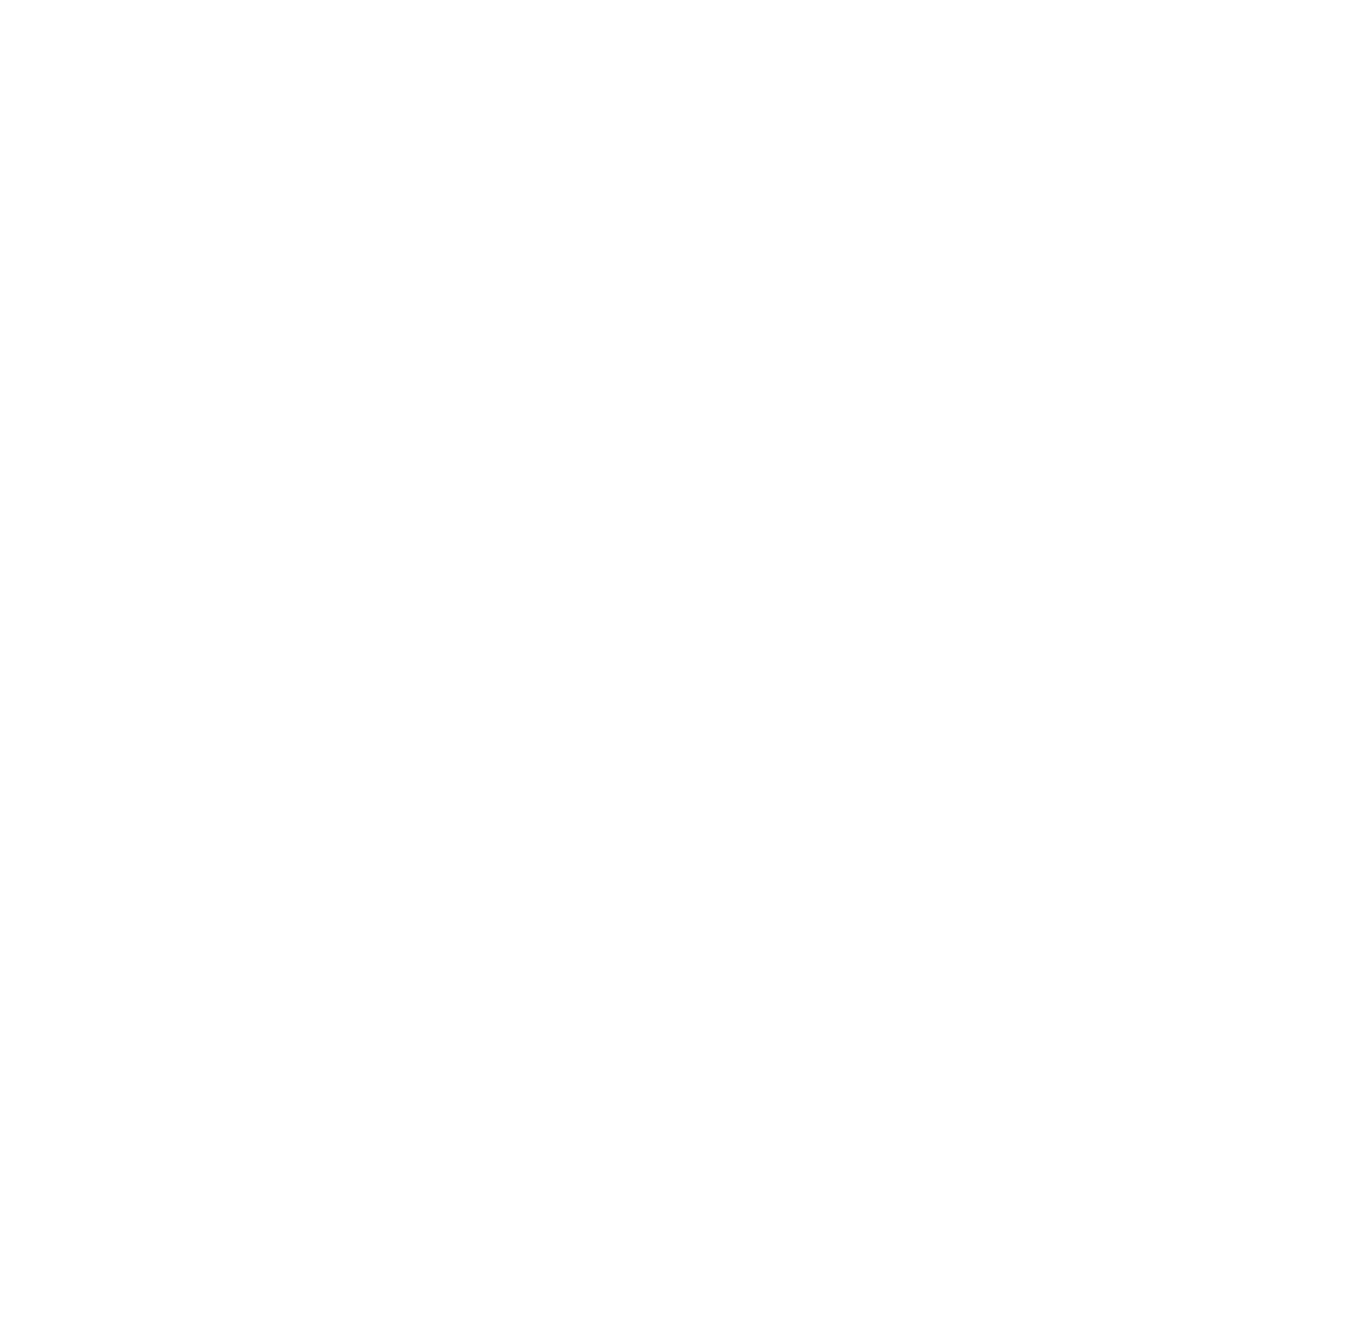

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(24, 24))
plot_tree(RF_pipeline.named_steps['learner'])
plt.show()